<a href="https://colab.research.google.com/github/abelowska/mlNeuro/blob/main/2025/MLN_spatial_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial filters


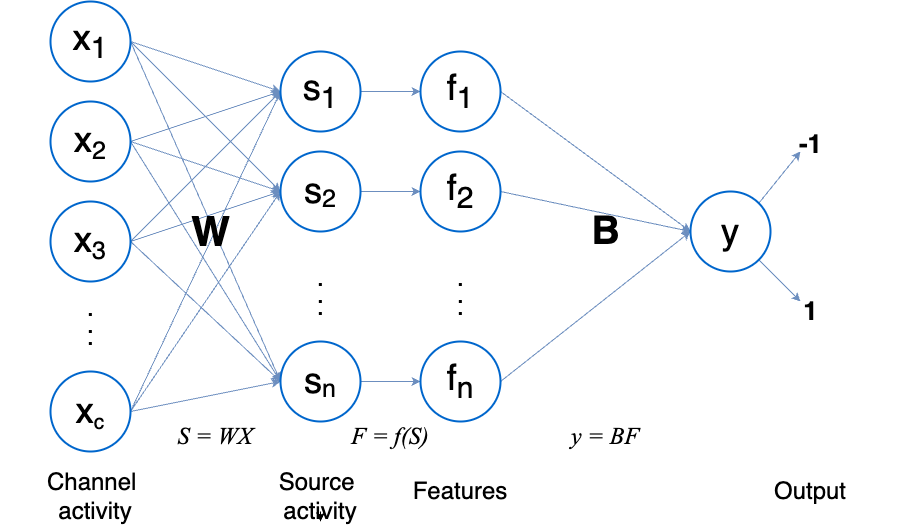


See the MNE wonderful tutorials and documantation to better understand spatial filters: [https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#spatial-filters](https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#spatial-filters)

In [ ]:
!pip install mne

Imports

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
from mne.datasets import eegbci
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter, CSP, Vectorizer
from mne.datasets import sample
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Load Motor Imagery dataset

We are going to use EEG data from EEGBCI Motor Imagery dataset available at [PhysioNet](https://physionet.org/content/eegmmidb/1.0.0/).

Read data and make basic pre-processing

In [ ]:
def read_motor_imagery_epochs(
    subject=1,
    runs=[4, 8, 12],
    tmin=-1.0,
    tmax=4.0,
    event_ids = ['left', 'right'],
    ):

  # load data from PhysioNet
  raw_fnames = eegbci.load_data(subject, runs)
  raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
  eegbci.standardize(raw)  # set channel names

  # set channels locations
  montage = make_standard_montage("standard_1005")
  raw.set_montage(montage)

  # rename annotations in raw
  raw.annotations.rename(dict(T1=event_ids[0], T2=event_ids[1]))

  # re-reference signal
  raw.set_eeg_reference(projection=True)

  # apply band-pass filter
  l_freq = 1.0
  h_freq = 30.0
  raw_filtered = raw.filter(
      l_freq,
      h_freq,
      fir_design="firwin",
      skip_by_annotation="edge"
  )
  # apply Notch at 60 Hz
  power_freq = 60
  nyquist_freq = raw_filtered.info['sfreq'] / 2

  raw_filtered = raw_filtered.notch_filter(
      picks=['eeg', 'eog'],
      freqs=np.arange(power_freq, nyquist_freq, power_freq),
      n_jobs=10,
  )

  # pick only eeg channels
  picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

  # create epochs
  epochs = Epochs(
      raw_filtered,
      event_id=event_ids,
      tmin=tmin,
      tmax=tmax,
      proj=True,
      picks=picks,
      baseline=None,
      preload=True,
  )

  return epochs

In [ ]:
subject = 1
runs = [4, 8, 12]  # motor imagery: left vs right tasks
event_ids = ['left', 'right']

tmin, tmax = -1.0, 2.0

epochs = read_motor_imagery_epochs(
    subject=subject,
    runs=runs,
    tmin=tmin,
    tmax=tmax,
    event_ids = event_ids,
    )

### Look into data

In [ ]:
epochs

Visualize data

1. Joint plot per condition

In [ ]:
fig = epochs['left'].average().plot_joint(times=[0.5, 0.8, 1.5, 2.0])
fig = epochs['right'].average().plot_joint(times=[0.5, 0.8, 1.5, 2.0])

2. Single-channel plots

In [ ]:
picks = ['C3', 'Cz', 'C4']

motor_evokeds = dict(
    left=list(epochs["left"].iter_evoked()),
    right=list(epochs["right"].iter_evoked()),
)

for idx, pick in enumerate(picks):
  plt.figure(idx)
  fig = mne.viz.plot_compare_evokeds(motor_evokeds, picks=pick)
  plt.show()

## Look into different spatial filters solutions

In [ ]:
# create epochs from 1s after cue onset till 2s
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)

#### PCA

1. Fit PCA to all data

In [ ]:
# define PCA
n_components = 2
pca = UnsupervisedSpatialFilter(
    estimator = PCA(n_components),
    average=False
    )

# get data to train PCA
X = epochs_train.get_data(copy=False)
print(f"Data shape for PCA: {X.shape}")

# fit PCA
pca.fit(X)

# extract sklearn PCA object
pca_estimator = pca.estimator

2. Explore PCA

Note, that PCA components has shape of *(n_components, n_channels)*, as each channel is a sample for PCA.

In [ ]:
# shape of PCA components
print(f"Shape of PCA solution, aka filters (n_components x n_channels): {pca_estimator.components_.shape}\n")

# explained variance of X
print(f"Explained variance of subsequent components: {pca_estimator.explained_variance_ratio_}")

You can use mne tool for vizualization to see the PCA weights that were estimated for each channel, i.e., filters. They show how each channel contribute to the given PCA component.

In [ ]:
for i in np.arange(0, n_components):
  # create canvas
  plt.figure(i)

  # get data of i-th component
  spatial_data = pca_estimator.components_[i]
  mne.viz.plot_topomap(
      spatial_data,
      pos=epochs_train.info,
      show=False
  )

  plt.show()

3. Transform data using fitted PCA

In [ ]:
X_filtered = pca.transform(X)
print(f'X shape befor PCA: {X.shape}\nX shape after PCA: {X_filtered.shape}')

The easiest way to check if PCA captured the difference between the conditions, and thus is suitable for our analysis, is to wrap data transformed with PCA to `Epochs` object that store info on events.

In [ ]:
# original data
print(epochs_train)

# create info for transformed data with 2 channels
events = epochs_train.events

info = mne.create_info(
    n_components,
    epochs_train.info['sfreq'],
    ch_types='eeg'
)

# create new epochs with the transformed data
motor_epochs_pca = mne.EpochsArray(
    X_filtered,
    info,
    events,
    tmin=epochs_train.tmin
)
print(motor_epochs_pca)

Now we can use all MNE methods for visualization of PCA-transformed epochs

In [ ]:
# pick the first component
picks = ['0']

motor_evokeds_pca = dict(
    left=list(motor_epochs_pca["2"].iter_evoked()),
    right=list(motor_epochs_pca["3"].iter_evoked()),
)

fig = mne.viz.plot_compare_evokeds(motor_evokeds_pca, picks=picks)

#### CSP

1. Fit CSP to all data

Note that because CSP is a supervised method, we have to provide the *y* set to CSP.

In [ ]:
# define CSP
n_components = 2
csp = CSP(n_components)

# get data to train CSP
X = epochs_train.get_data(copy=False)
y = epochs_train.events[:, -1] - 1

# fit CSP
csp.fit(X, y)

2. Explore CSP

Using build-in functions we can easily plot:
- **patterns** (also called mixing matrix - $A$): $S * A = X$
- **filters** (CSP weights; also called de-mixing matrix - $W$): $X * W = S$

where $X$ is data observed on channels and $S$ is a 'real' source data.

In [ ]:
print(f"EEG filters\n")
fig = csp.plot_filters(epochs_train.info)

print(f"EEG patterns\n")
fig = csp.plot_patterns(epochs_train.info)

3. Transform the original data

In [ ]:
X_filtered_csp = csp.transform(X)
print(f'X shape befor PCA: {X.shape}\nX shape after PCA: {X_filtered_csp.shape}')

CSP does not preserve the time dimension; it averages the signal along the time domain. As a result of CSP, we obtain as many features as the number of CSP components we declare.

## Classification with spatial filters and LDA

Prepare data

In [ ]:
epochs_data_train = epochs_train.get_data(copy=False)
labels = epochs_train.events[:, -1] - 2

In [ ]:
# define CV - we do not have test dataset
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
scaler = StandardScaler()
lda = LinearDiscriminantAnalysis()
clf = make_pipeline(csp, scaler, lda)

# calculate CV scores of out model
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, scoring='accuracy', n_jobs=None)

# print the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

Plot patterns and filters

In [ ]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data_train, labels)
csp.plot_patterns(epochs_train.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

## Exercise:

Try to implement classification pipeline similar to the one above, but use `PCA` as a spatial filter. Do not forget wrap `PCA` into `UnsupervisedSpatialFilter`, and then use `Vectorizer` to flatten `(n_epochs, n_channels, n_timepoints)` into `(n_epochs, n_samples).`

In [ ]:
# your code here